In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

# Load the file
file_path = r'C:\Users\Yash Malik\Downloads\hst_mos_0017053_acs_wfc_f555w_sci.fits'  # Adjust this
with fits.open(file_path) as hdu_list:
    # Print info about all HDUs
    print("Number of HDUs:", len(hdu_list))
    for i, hdu in enumerate(hdu_list):
        print(f"\nHDU {i}:")
        print(f"Header: {hdu.header}")
        print(f"Data type: {type(hdu.data)}")
        print(f"Data shape: {hdu.data.shape if hdu.data is not None else 'None'}")

    # Try to find the image data
    for i, hdu in enumerate(hdu_list):
        if hdu.data is not None and isinstance(hdu.data, np.ndarray):
            sci_data = hdu.data
            sci_header = hdu.header
            print(f"\nFound image data in HDU {i}:")
            print("Header Info:", sci_header)
            print("Image Shape:", sci_data.shape)
            break
    else:
        print("No image data found in any HDU.")

Number of HDUs: 2

HDU 0:
Header: SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H                                                                                 TELESCOP= 'HST'                / telescope used to acquire data                 INSTRUME= 'ACS   '             / identifier for instrument used to acquire data                                                                                               / DATA DESCRIPTION KEYWORDS                                                                                                                       IMAGET

Image found in HDU 1
Header Info: XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                11900                                                  NAXIS2  =                 9200                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               INHERIT =                    T / inherit the primary header                     EXTNAME = 'SCI     '           / extension name                                 EXTVER  =                    1                                                  BUNIT   = 'ELECTRONS/S'        / Units of science product                                                                                                       CD1_1 

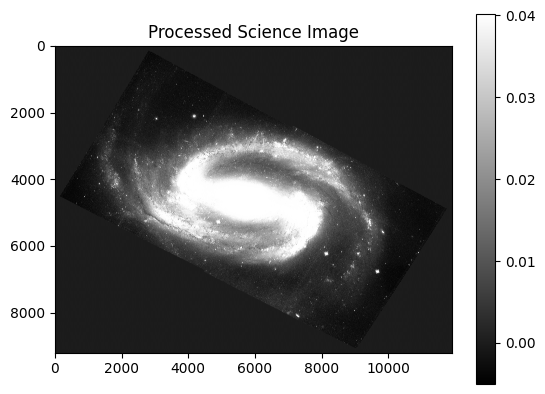

In [4]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

file_path = r'C:\Users\Yash Malik\Downloads\hst_mos_0017053_acs_wfc_f555w_sci.fits'  # Adjust this
with fits.open(file_path) as hdu_list:
    # Find the HDU with image data
    for i, hdu in enumerate(hdu_list):
        if hdu.data is not None and isinstance(hdu.data, np.ndarray):
            sci_data = hdu.data
            sci_header = hdu.header
            print(f"Image found in HDU {i}")
            print("Header Info:", sci_header)
            print("Image Shape:", sci_data.shape)
            plt.imshow(sci_data, cmap='gray', vmin=np.percentile(sci_data, 5), vmax=np.percentile(sci_data, 95))
            plt.title('Processed Science Image')
            plt.colorbar()
            plt.show()
            break
    else:
        print("No image data found in the file.")

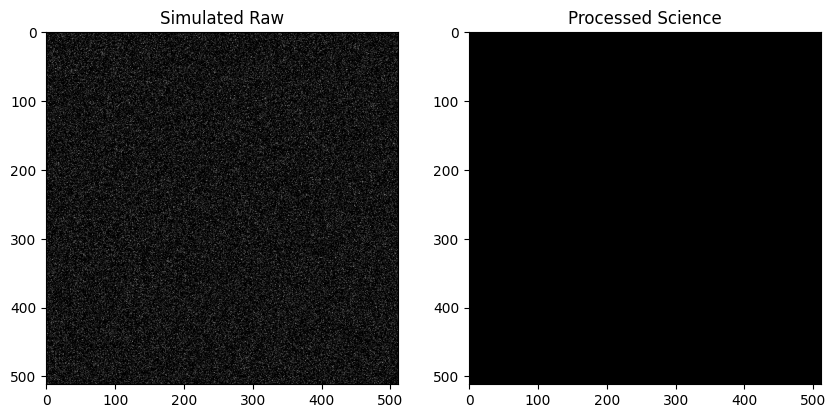

2025-03-30 20:39:33,000 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|20/20, best_cost=0.00039
2025-03-30 20:39:38,021 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.00038998223449979885, best pos: [16.66519597]


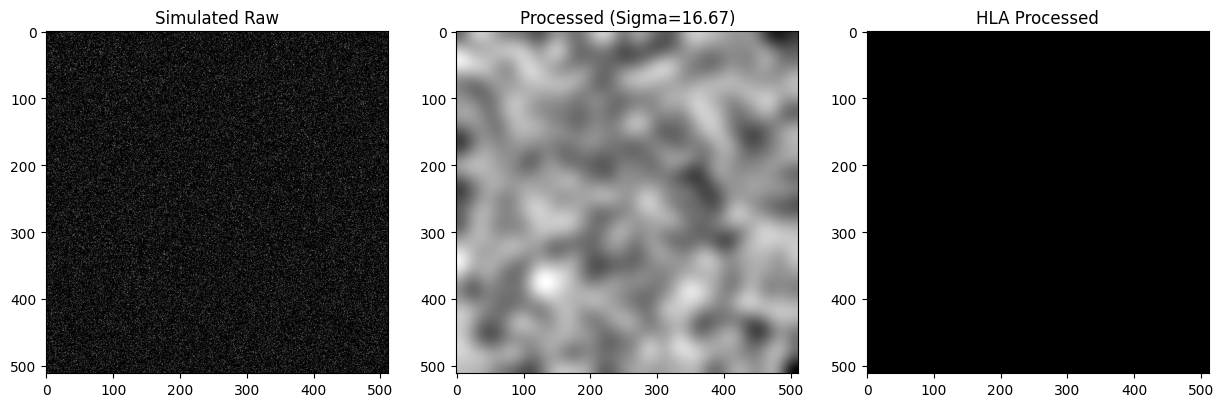

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import pyswarms as ps

# Load FITS file
file_path = r'C:\Users\Yash Malik\Downloads\hst_mos_0017053_acs_wfc_f555w_sci.fits'  # Adjust this
with fits.open(file_path) as hdu_list:
    for i, hdu in enumerate(hdu_list):
        if hdu.data is not None and isinstance(hdu.data, np.ndarray):
            sci_data = hdu.data
            sci_header = hdu.header
            break

# Preprocess
sci_data_normalized = (sci_data - np.min(sci_data)) / (np.max(sci_data) - np.min(sci_data))
raw_simulated = sci_data_normalized + np.random.normal(0, 0.05, sci_data.shape)
raw_simulated = np.clip(raw_simulated, 0, 1)
raw_simulated = np.nan_to_num(raw_simulated, nan=0.0, posinf=1.0, neginf=0.0)
sci_data_normalized = np.nan_to_num(sci_data_normalized, nan=0.0, posinf=1.0, neginf=0.0)
crop_size = 512
raw_simulated_cropped = raw_simulated[:crop_size, :crop_size]
sci_data_cropped = sci_data_normalized[:crop_size, :crop_size]

# Visualize before processing
plt.figure(figsize=(10, 5))
plt.subplot(121); plt.imshow(raw_simulated_cropped, cmap='gray'); plt.title('Simulated Raw')
plt.subplot(122); plt.imshow(sci_data_cropped, cmap='gray'); plt.title('Processed Science')
plt.show()

# Fitness function
def fitness(params, raw_image, ref_image):
    processed = gaussian_filter(raw_image, sigma=params[0])
    return np.mean((processed - ref_image) ** 2)

# Optimize with PSO
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=1, options={'c1': 0.5, 'c2': 0.3, 'w': 0.9})
best_cost, best_params = optimizer.optimize(
    lambda x: [fitness(p, raw_simulated_cropped, sci_data_cropped) for p in x], iters=20
)

# Process and visualize result
processed_image = gaussian_filter(raw_simulated_cropped, sigma=best_params[0])
plt.figure(figsize=(15, 5))
plt.subplot(131); plt.imshow(raw_simulated_cropped, cmap='gray'); plt.title('Simulated Raw')
plt.subplot(132); plt.imshow(processed_image, cmap='gray'); plt.title(f'Processed (Sigma={best_params[0]:.2f})')
plt.subplot(133); plt.imshow(sci_data_cropped, cmap='gray'); plt.title('HLA Processed')
plt.show()